# Vertigo & Imbalance Survey — Exploratory Analysis

This notebook loads the provided survey CSV and performs basic exploratory analysis using **pandas** and **NumPy**.


In [200]:
import pandas as pd
import numpy as np

CSV_PATH = r"public/files/raw_vertigo_survey_form_responses.csv"
df = pd.read_csv(CSV_PATH)
df.head()


,NAME,AGE,GENDER,CONTACT NO./ EMAIL- ID,JOB ROLE,TYPICAL DAILY WORKING HOURS,HOW MANY HOURS DO YOU SPEND IN FRONT OF SCREEN DAILY?,DOES YOUR WORK INVOLVE USAGE OR EARPHONES/HEADPHONES,IF YES THEN FOR HOW MANY HOURS?,"1. Riding as a passenger in a car on straight, flat roads",...,11. Heights,12. Watching moving scenes on the T.V. or at the cinema,13. Travelling on escalators,"14. Looking at striped or moving surfaces \n(e.g. curtains, Venetian blinds, flowing water)",15. Looking at a scrolling computer screen or microfiche,16. Going through a tunnel looking at the lights on the side,17. Going through a tunnel looking at the light at the end,"18. Driving over the brow of a hill, around bends, or in \nwide open spaces","19. Watching moving traffic or trains \n(e.g. trying to cross the street, or at the station)",SVQ Score
0,Mayur,20-29,Male,mayur.girnarmg@gmail.com,Software developer,8,> 8 hours,Yes,<4 hours,0- not at all,...,2- somewhat,1- very slightly,0- not at all,1- very slightly,1- very slightly,1- very slightly,1- very slightly,0- not at all,1- very slightly,NaN
1,Ruturaj Chavan,20-29,Male,ruturajc1234@gmail.com,IT,10~,> 8 hours,Yes,4-6 hours4,0- not at all,...,0- not at all,0- not at all,0- not at all,0- not at all,0- not at all,0- not at all,0- not at all,0- not at all,0- not at all,NaN
2,Tabish Ali Ansari,20-29,Male,tabish.ansari@aissmsioit.org,Software Development Intern,9,> 8 hours,Yes,<4 hours,2- somewhat,...,1- very slightly,3- quiet a lot,1- very slightly,1- very slightly,2- somewhat,2- somewhat,2- somewhat,2- somewhat,1- very slightly,NaN
3,Jayshree Kaple,20-29,Female,9307315557,System Implementor,9,6-8 hours,Yes,4-6 hours4,0- not at all,...,1- very slightly,0- not at all,0- not at all,1- very slightly,1- very slightly,N.T.,N.T.,0- not at all,0- not at all,NaN
4,Atul Kaple,20-29,Male,kapleatul@gmail.com,Full Stack Developer,8,> 8 hours,Yes,4-6 hours4,0- not at all,...,0- not at all,0- not at all,N.T.,N.T.,0- not at all,0- not at all,0- not at all,0- not at all,0- not at all,NaN


## Cleaning & EDA Plan

**Cleaning goals**
- Standardize column names (trim spaces, normalize newlines)
- Standardize Likert responses (trim, fix known typos, keep N.T.)
- Preserve original data and create a cleaned copy

**EDA goals**
- Basic dataset overview (shape, missingness)
- Distributions for demographic/work columns
- Response distributions for each SVQ item
- Validate SVQ scores after cleaning

After the EDA, we will export a processed CSV.

In [201]:
# Create a cleaned copy
raw_df = df.copy()

# 1) Clean column names
clean_columns = (
    pd.Series(raw_df.columns)
    .astype(str)
    .str.replace(r"\s+", " ", regex=True)
    .str.replace("\n", " ")
    .str.strip()
)
raw_df.columns = clean_columns

# 2) Standardize Likert values in SVQ question columns
question_cols = raw_df.columns[9:28]

# Normalize strings: trim + collapse spaces
raw_df[question_cols] = raw_df[question_cols].apply(
    lambda s: s.map(lambda x: str(x).strip().replace("  ", " ") if pd.notna(x) else x)
)

# Fix known typo variants
likert_fixes = {
    "3- quiet a": "3- quiet a lot",
    "3- quiet a ": "3- quiet a lot",
}

raw_df[question_cols] = raw_df[question_cols].replace(likert_fixes)

# 3) Standardize N.T. values (case/spacing)
raw_df[question_cols] = raw_df[question_cols].apply(
    lambda s: s.map(lambda x: "N.T." if isinstance(x, str) and x.strip().upper() in {"N.T.", "NT"} else x)
)

# 4) Standardize Job Role values (trim, title case, consolidate variations)
job_role_col = "JOB ROLE"
if job_role_col in raw_df.columns:
    # Trim whitespace and standardize capitalization
    raw_df[job_role_col] = raw_df[job_role_col].astype(str).str.strip().str.title()
    
    # Create mapping for known variations/consolidations
    job_role_mapping = {
        "Software Developer": "Software Developer",
        "Software Engineer": "Software Engineer",
        "Data Analyst": "Data Analyst",
        "It": "IT",
        "It Worker": "IT Worker",
        "It Professional": "IT Professional",
    }
    
    # Apply consolidation mapping
    raw_df[job_role_col] = raw_df[job_role_col].replace(job_role_mapping)

# Save cleaned dataframe for downstream steps
clean_df = raw_df.copy()

print("Cleaning complete.")
print("Columns cleaned:", len(clean_df.columns))
print("Question columns:", len(question_cols))


Cleaning complete.
Columns cleaned: 29
Question columns: 19


In [202]:
# EDA: overview and missingness
print("Shape:", clean_df.shape)
print("\nMissing values (top 10):")
missing = clean_df.isna().sum().sort_values(ascending=False)
print(missing.head(10))

# EDA: key demographic/work distributions
categorical_cols = [
    "AGE",
    "GENDER",
    "JOB ROLE",
    "TYPICAL DAILY WORKING HOURS",
    "HOW MANY HOURS DO YOU SPEND IN FRONT OF SCREEN DAILY?",
    "DOES YOUR WORK INVOLVE USAGE OR EARPHONES/HEADPHONES",
]

for col in categorical_cols:
    if col in clean_df.columns:
        print(f"\n{col}")
        print(clean_df[col].value_counts(dropna=False).head(10))


Shape: (115, 29)

Missing values (top 10):
SVQ Score                                                    115
JOB ROLE                                                       5
NAME                                                           0
GENDER                                                         0
AGE                                                            0
TYPICAL DAILY WORKING HOURS                                    0
HOW MANY HOURS DO YOU SPEND IN FRONT OF SCREEN DAILY?          0
DOES YOUR WORK INVOLVE USAGE OR EARPHONES/HEADPHONES           0
IF YES THEN FOR HOW MANY HOURS?                                0
1. Riding as a passenger in a car on straight, flat roads      0
dtype: int64

AGE
AGE
20-29    80
30-39    28
40-50     7
Name: count, dtype: int64

GENDER
GENDER
Male      63
Female    52
Name: count, dtype: int64

JOB ROLE
JOB ROLE
IT                             22
Software Developer             17
Software Engineer              12
IT Worker                       8
D

In [203]:
# EDA: response distribution per SVQ item (top 6 values)
print("\nSVQ response distributions (top 6 each):")
for col in question_cols:
    print(f"\n{col}")
    print(clean_df[col].value_counts(dropna=False).head(6))


SVQ response distributions (top 6 each):

1. Riding as a passenger in a car on straight, flat roads
1. Riding as a passenger in a car on straight, flat roads
1- very slightly    34
2- somewhat         31
0- not at all       30
3- quiet a lot      14
N.T.                 4
4- very much         2
Name: count, dtype: int64

2. Riding as a passenger in a car on winding or bumpy roads.
2. Riding as a passenger in a car on winding or bumpy roads.
2- somewhat         32
0- not at all       30
3- quiet a lot      24
1- very slightly    23
4- very much         5
N.T.                 1
Name: count, dtype: int64

3. Walking down a supermarket aisle.
3. Walking down a supermarket aisle.
0- not at all       33
2- somewhat         29
1- very slightly    23
3- quiet a lot      14
4- very much        10
N.T.                 6
Name: count, dtype: int64

4. Standing in a Lift while it stops.
4. Standing in a Lift while it stops.
0- not at all       29
1- very slightly    24
2- somewhat         23
3- qu

## SVQ Item Response Distribution (Stacked Bar Chart)

Horizontal stacked bars showing the percentage distribution of responses for each SVQ question.

✓ SVQ stacked bar chart saved to: output/svq_item_response_stacked_bar.png


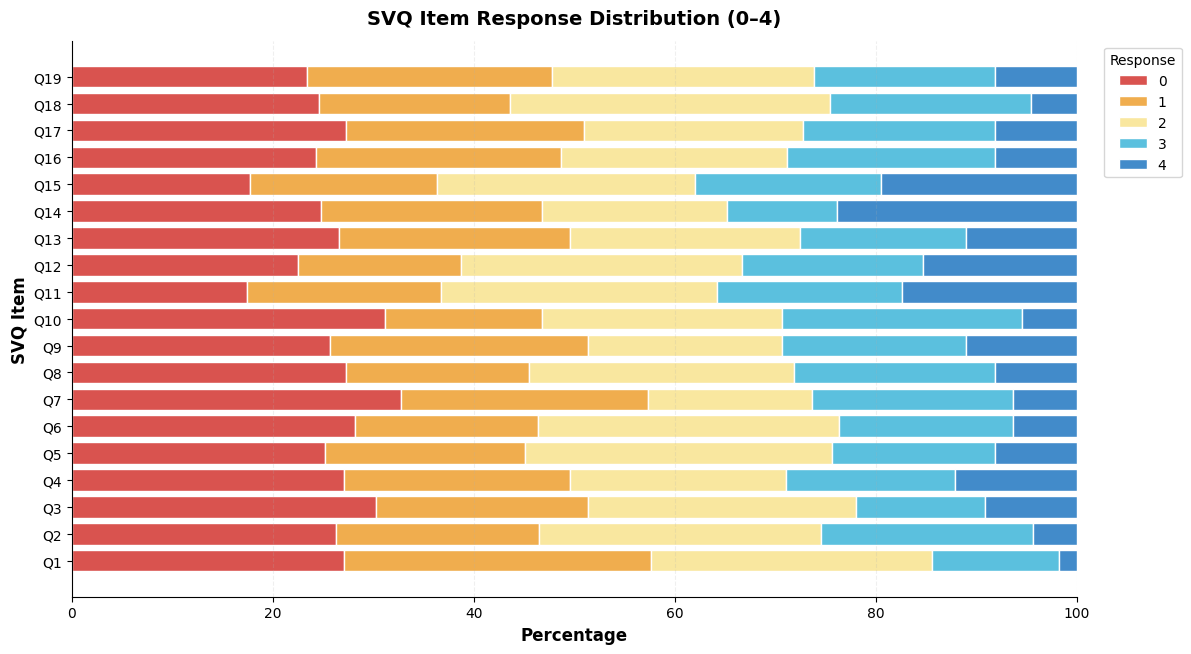

In [204]:
# Horizontal stacked bar chart for SVQ item response distributions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Convert SVQ responses to numeric (0-4), exclude N.T.
svq_numeric = clean_df[question_cols].apply(lambda s: s.map(extract_numeric_value_clean))

# Build percentage distribution for each item
response_levels = [0, 1, 2, 3, 4]
response_labels = ["0", "1", "2", "3", "4"]
colors = ["#d9534f", "#f0ad4e", "#f9e79f", "#5bc0de", "#428bca"]  # red → blue

# Percentages per question
percentage_df = pd.DataFrame(index=question_cols, columns=response_levels)
for col in question_cols:
    counts = svq_numeric[col].value_counts(normalize=True).reindex(response_levels, fill_value=0)
    percentage_df.loc[col] = counts.values * 100

percentage_df = percentage_df.astype(float)

# Plot
fig, ax = plt.subplots(figsize=(12, max(6, len(question_cols) * 0.35)))
left = np.zeros(len(percentage_df))

for level, label, color in zip(response_levels, response_labels, colors):
    values = percentage_df[level].values
    ax.barh(percentage_df.index, values, left=left, color=color, edgecolor="white", label=label)
    left += values

ax.set_xlabel("Percentage", fontsize=12, fontweight="bold")
ax.set_ylabel("SVQ Item", fontsize=12, fontweight="bold")
ax.set_title("SVQ Item Response Distribution (0–4)", fontsize=14, fontweight="bold", pad=12)
ax.set_xlim(0, 100)
ax.grid(axis="x", alpha=0.2, linestyle="--")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Improve label readability
ax.set_yticks(range(len(question_cols)))
ax.set_yticklabels([f"Q{i+1}" for i in range(len(question_cols))])

# Legend
ax.legend(title="Response", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()

# Save figure
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
stacked_path = os.path.join(output_dir, "svq_item_response_stacked_bar.png")
plt.savefig(stacked_path, dpi=300, bbox_inches="tight", facecolor="white")
print(f"✓ SVQ stacked bar chart saved to: {stacked_path}")

plt.show()

In [205]:
# Recalculate SVQ Score on cleaned data

def extract_numeric_value_clean(response):
    if pd.isna(response) or response == 'N.T.':
        return None
    response_str = str(response).strip()
    if response_str.startswith('0'):
        return 0
    if response_str.startswith('1'):
        return 1
    if response_str.startswith('2'):
        return 2
    if response_str.startswith('3'):
        return 3
    if response_str.startswith('4'):
        return 4
    return None


def calculate_svq_score_clean(row):
    values = []
    for col in question_cols:
        numeric_val = extract_numeric_value_clean(row[col])
        if numeric_val is not None:
            values.append(numeric_val)
    if len(values) == 0:
        return np.nan
    return sum(values) / len(values)

clean_df['SVQ Score'] = clean_df.apply(calculate_svq_score_clean, axis=1)
clean_df['SVQ Score'] = clean_df['SVQ Score'].round(6)

print("SVQ Score stats (cleaned):")
print(clean_df['SVQ Score'].describe())


SVQ Score stats (cleaned):
count    114.000000
mean       1.625234
std        1.017037
min        0.000000
25%        0.736842
50%        1.736842
75%        2.368421
max        4.000000
Name: SVQ Score, dtype: float64


In [206]:
# Classify SVQ Scores based on interpretation
def classify_svq_score(score):
    """
    Classify SVQ score according to interpretation:
    0-1: Minimal or no symptoms triggered by situations
    2-3: Moderate symptoms, some visual dependence
    4: High sensitivity, substantial visual vertigo
    """
    if pd.isna(score):
        return "Unknown"
    elif score <= 1:
        return "Minimal/No Symptoms"
    elif score <= 3:
        return "Moderate Symptoms"
    else:
        return "High Sensitivity"

clean_df['SVQ Interpretation'] = clean_df['SVQ Score'].apply(classify_svq_score)

print("SVQ Score Classification:")
print(clean_df[['SVQ Score', 'SVQ Interpretation']].head(15))


SVQ Score Classification:
    SVQ Score   SVQ Interpretation
0    0.526316  Minimal/No Symptoms
1    0.000000  Minimal/No Symptoms
2    1.894737    Moderate Symptoms
3    0.352941  Minimal/No Symptoms
4    0.000000  Minimal/No Symptoms
5    1.368421    Moderate Symptoms
6    2.000000    Moderate Symptoms
7    0.000000  Minimal/No Symptoms
8    1.071429    Moderate Symptoms
9    2.526316    Moderate Symptoms
10   0.368421  Minimal/No Symptoms
11   2.333333    Moderate Symptoms
12   0.736842  Minimal/No Symptoms
13   2.000000    Moderate Symptoms
14   0.684211  Minimal/No Symptoms


In [207]:
print("\nClassification Distribution:")
print(clean_df['SVQ Interpretation'].value_counts())


Classification Distribution:
SVQ Interpretation
Moderate Symptoms      68
Minimal/No Symptoms    36
High Sensitivity       10
Unknown                 1
Name: count, dtype: int64


## Statistical Inference - Prevalence Calculation

**Primary Objective**: Calculate prevalence of vertigo/imbalance symptoms in IT workers

**Definitions for Prevalence:**
- **Symptomatic** = Moderate Symptoms + High Sensitivity
- **Asymptomatic** = Minimal/No Symptoms

**Formula:**  
Prevalence = (Number of Symptomatic participants / Total participants) × 100

In [208]:
# Calculate Prevalence of Vertigo/Imbalance Symptoms

# Count participants by category
total_participants = len(clean_df[clean_df['SVQ Interpretation'] != 'Unknown'])
minimal = len(clean_df[clean_df['SVQ Interpretation'] == 'Minimal/No Symptoms'])
moderate = len(clean_df[clean_df['SVQ Interpretation'] == 'Moderate Symptoms'])
high_sensitivity = len(clean_df[clean_df['SVQ Interpretation'] == 'High Sensitivity'])

# Calculate symptomatic (Moderate + High Sensitivity)
symptomatic = moderate + high_sensitivity
asymptomatic = minimal

# Calculate prevalence
prevalence = (symptomatic / total_participants) * 100

print("="*60)
print("PREVALENCE CALCULATION")
print("="*60)
print(f"\nTotal Participants (excluding Unknown): {total_participants}")
print(f"\nAsymptomatic (Minimal/No Symptoms): {asymptomatic} ({asymptomatic/total_participants*100:.2f}%)")
print(f"\nSymptomatic Breakdown:")
print(f"  - Moderate Symptoms: {moderate} ({moderate/total_participants*100:.2f}%)")
print(f"  - High Sensitivity: {high_sensitivity} ({high_sensitivity/total_participants*100:.2f}%)")
print(f"  - Total Symptomatic: {symptomatic} ({symptomatic/total_participants*100:.2f}%)")
print(f"\n{'='*60}")
print(f"PREVALENCE OF VERTIGO/IMBALANCE SYMPTOMS: {prevalence:.2f}%")
print(f"{'='*60}")



PREVALENCE CALCULATION

Total Participants (excluding Unknown): 114

Asymptomatic (Minimal/No Symptoms): 36 (31.58%)

Symptomatic Breakdown:
  - Moderate Symptoms: 68 (59.65%)
  - High Sensitivity: 10 (8.77%)
  - Total Symptomatic: 78 (68.42%)

PREVALENCE OF VERTIGO/IMBALANCE SYMPTOMS: 68.42%


## Prevalence Distribution (Pie Chart)

Visualization of symptomatic vs asymptomatic participants.

✓ SVQ severity pie chart saved to: output/svq_severity_pie_chart.png


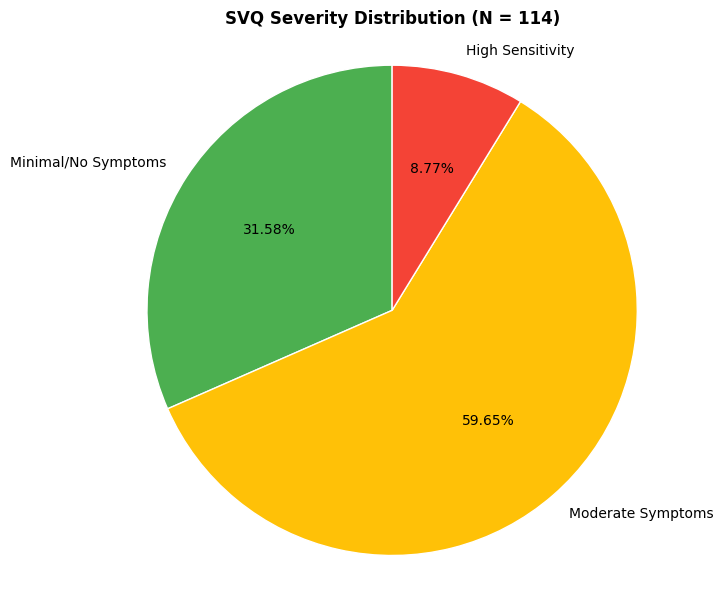

In [209]:
# Pie chart for SVQ severity categories

import matplotlib.pyplot as plt
import os

labels = ["Minimal/No Symptoms", "Moderate Symptoms", "High Sensitivity"]
values = [minimal, moderate, high_sensitivity]
colors = ["#4CAF50", "#FFC107", "#F44336"]

fig, ax = plt.subplots(figsize=(7, 6))
wedges, texts, autotexts = ax.pie(
    values,
    labels=labels,
    autopct="%1.2f%%",
    startangle=90,
    colors=colors,
    textprops={"fontsize": 10},
    wedgeprops={"edgecolor": "white", "linewidth": 1}
)

ax.set_title(f"SVQ Severity Distribution (N = {total_participants})",
             fontsize=12, fontweight="bold", pad=12)
ax.axis("equal")

plt.tight_layout()

# Save figure
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
prevalence_pie_path = os.path.join(output_dir, "svq_severity_pie_chart.png")
plt.savefig(prevalence_pie_path, dpi=300, bbox_inches="tight", facecolor="white")
print(f"✓ SVQ severity pie chart saved to: {prevalence_pie_path}")

plt.show()

In [210]:

# Summary statements
print("\n" + "="*60)
print("SUMMARY STATEMENTS")
print("="*60)
print(f"\nAmong the participants, {asymptomatic/total_participants*100:.2f}% had minimal symptoms, "
      f"{moderate/total_participants*100:.2f}% had moderate symptoms, and "
      f"{high_sensitivity/total_participants*100:.2f}% showed high sensitivity to visual vertigo situations.")
print(f"\nThe prevalence of moderate to high vertigo/imbalance-related symptoms "
      f"among IT workers was {prevalence:.2f}%.")
print("="*60)


SUMMARY STATEMENTS

Among the participants, 31.58% had minimal symptoms, 59.65% had moderate symptoms, and 8.77% showed high sensitivity to visual vertigo situations.

The prevalence of moderate to high vertigo/imbalance-related symptoms among IT workers was 68.42%.


In [211]:
# Save processed CSV after cleaning + SVQ recomputation + classification
import os
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

processed_path = os.path.join(output_dir, 'vertigo_survey_processed.csv')
clean_df.to_csv(processed_path, index=False)

print(f"Processed CSV saved to: {processed_path}")
print(f"Total rows: {len(clean_df)}")
print(f"Columns: {list(clean_df.columns[-2:])}")


Processed CSV saved to: output/vertigo_survey_processed.csv
Total rows: 115
Columns: ['SVQ Score', 'SVQ Interpretation']


## Descriptive Statistics - Table 1

Summary of participant demographics and clinical characteristics


In [212]:
# Prepare data for Table 1

# Prepare data (exclude Unknown SVQ status)
table1_df = clean_df[clean_df['SVQ Interpretation'] != 'Unknown'].copy()

# Map continuous variables
screen_col = "HOW MANY HOURS DO YOU SPEND IN FRONT OF SCREEN DAILY?"
screen_mapping = {
    "> 8 hours": 8.5,
    "6-8 hours": 7,
    "4-6 hours": 5,
    "<4 hours": 2,
}
table1_df['Screen_hours'] = table1_df[screen_col].map(screen_mapping)

earphone_col = "IF YES THEN FOR HOW MANY HOURS?"
earphone_mapping = {
    "<4 hours": 2,
    "4-6 hours4": 5,
    "6-8 hours": 7,
    ">8hours": 8.5,
}
table1_df['Earphone_hours'] = table1_df[earphone_col].map(earphone_mapping)

# Data preparation complete, ready for formatting


In [213]:
# Format Table 1 as Publication-Ready Table (using Matplotlib)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Calculate statistics dynamically
age_mean = table1_df['AGE'].astype(str).str.extract(r'(\d+)')[0].astype(int).mean()
age_std = table1_df['AGE'].astype(str).str.extract(r'(\d+)')[0].astype(int).std()

screen_mean = table1_df['Screen_hours'].mean()
screen_std = table1_df['Screen_hours'].std()

earphone_mean = table1_df['Earphone_hours'].mean()
earphone_std = table1_df['Earphone_hours'].std()

svq_mean = table1_df['SVQ Score'].mean()
svq_std = table1_df['SVQ Score'].std()

# Gender statistics
gender_counts = table1_df['GENDER'].value_counts()
gender_list = []
for gender, count in gender_counts.items():
    pct = (count / len(table1_df)) * 100
    gender_list.append((f'  {gender}', f'{count} ({pct:.2f}%)'))

# Job Role statistics (top 6)
job_counts = table1_df['JOB ROLE'].value_counts().head(6)
job_list = []
for job, count in job_counts.items():
    pct = (count / len(table1_df)) * 100
    job_list.append((f'  {job}', f'{count} ({pct:.2f}%)'))

# SVQ Status statistics
svq_counts = table1_df['SVQ Interpretation'].value_counts()
svq_list = []
for status, count in svq_counts.items():
    pct = (count / len(table1_df)) * 100
    svq_list.append((f'  {status}', f'{count} ({pct:.2f}%)'))

# Build table data dynamically
table1_data = {
    'Variable': [
        'Age (years)',
        'Screen Time (hours/day)',
        'Earphone Usage (hours/day)',
        'Total SVQ Score',
        '',
        'Gender',
    ] + [item[0] for item in gender_list] + [
        '',
        'Job Role (Top Categories)',
    ] + [item[0] for item in job_list] + [
        '',
        'SVQ Symptom Status',
    ] + [item[0] for item in svq_list],
    
    'Mean ± SD or n (%)': [
        f'{age_mean:.2f} ± {age_std:.2f}',
        f'{screen_mean:.2f} ± {screen_std:.2f}',
        f'{earphone_mean:.2f} ± {earphone_std:.2f}',
        f'{svq_mean:.4f} ± {svq_std:.4f}',
        '',
        '',
    ] + [item[1] for item in gender_list] + [
        '',
        '',
    ] + [item[1] for item in job_list] + [
        '',
        '',
    ] + [item[1] for item in svq_list]
}

# Identify section header indices for bold formatting
section_headers = ['Gender', 'Job Role (Top Categories)', 'SVQ Symptom Status']

table1_df_formatted = pd.DataFrame(table1_data)


✓ Table 1 image exported to: output/Table1_descriptive_statistics.png
✓ Table 1 CSV exported to: output/Table1_descriptive_statistics.csv


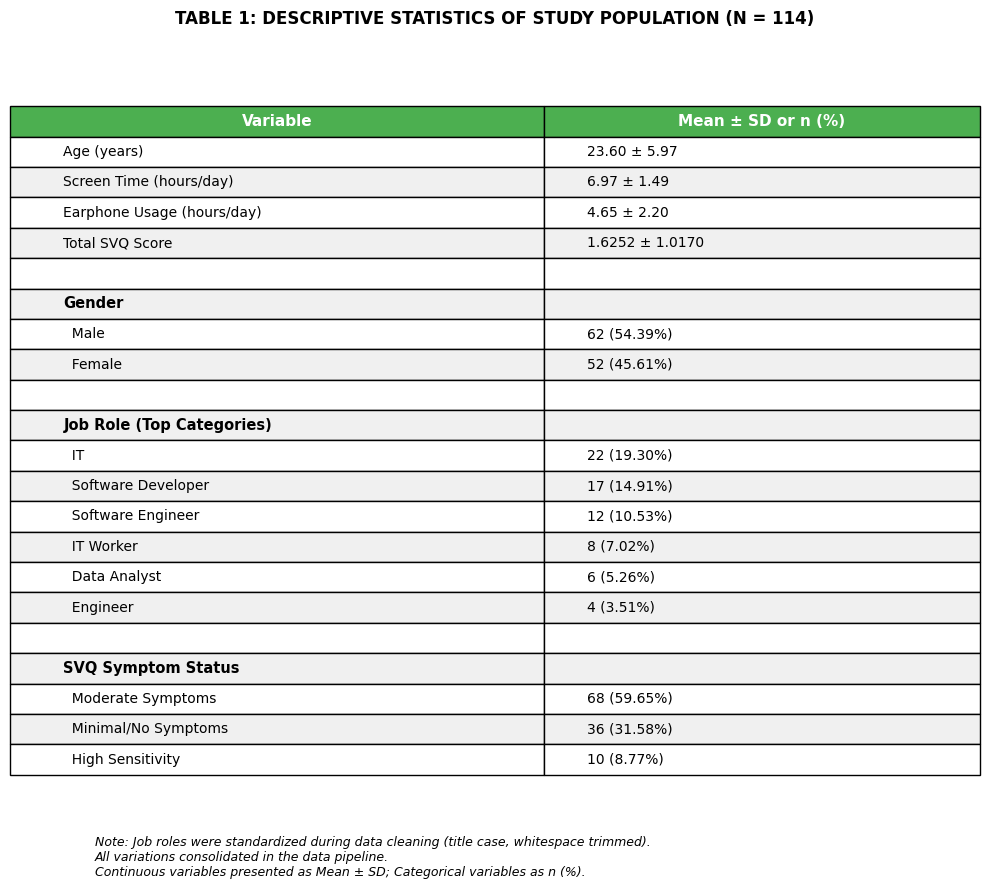


Table 1 visualization created successfully!


In [214]:
# Create matplotlib figure and table
fig, ax = plt.subplots(figsize=(10, 9))
ax.axis('tight')
ax.axis('off')

# Create table with alternating row colors
table = ax.table(cellText=table1_df_formatted.values,
                colLabels=table1_df_formatted.columns,
                cellLoc='left',
                loc='center',
                colWidths=[0.55, 0.45])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Header styling
for i in range(len(table1_df_formatted.columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#4CAF50')
    cell.set_text_props(weight='bold', color='white', fontsize=11)

# Alternate row colors and section header bolding
for i in range(1, len(table1_df_formatted) + 1):
    for j in range(len(table1_df_formatted.columns)):
        cell = table[(i, j)]
        # Light grey for even rows, white for odd rows
        if i % 2 == 0:
            cell.set_facecolor('#f0f0f0')
        else:
            cell.set_facecolor('#ffffff')
        
        # Bold for section headers
        if j == 0 and table1_df_formatted.iloc[i-1, 0] in section_headers:
            cell.set_text_props(weight='bold', fontsize=10.5)

# Add title
plt.suptitle('TABLE 1: DESCRIPTIVE STATISTICS OF STUDY POPULATION (N = 114)',
             fontsize=12, weight='bold', y=0.98)

# Add note
note_text = ('Note: Job roles were standardized during data cleaning (title case, whitespace trimmed).\n'
             'All variations consolidated in the data pipeline.\n'
             'Continuous variables presented as Mean ± SD; Categorical variables as n (%).')
plt.figtext(0.1, 0.02, note_text, ha='left', fontsize=9, style='italic', wrap=True)

plt.tight_layout(rect=[0, 0.08, 1, 0.96])

# Save as image
import os
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)

table1_image_path = os.path.join(output_dir, 'Table1_descriptive_statistics.png')
plt.savefig(table1_image_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Table 1 image exported to: {table1_image_path}")

# Also save as CSV
table1_csv_path = os.path.join(output_dir, 'Table1_descriptive_statistics.csv')
table1_df_formatted.to_csv(table1_csv_path, index=False)
print(f"✓ Table 1 CSV exported to: {table1_csv_path}")

# Display the table
plt.show()
print("\nTable 1 visualization created successfully!")

## Age Group Distribution

Distribution of study participants by age group

✓ Age group distribution chart saved to: output/age_group_distribution.png


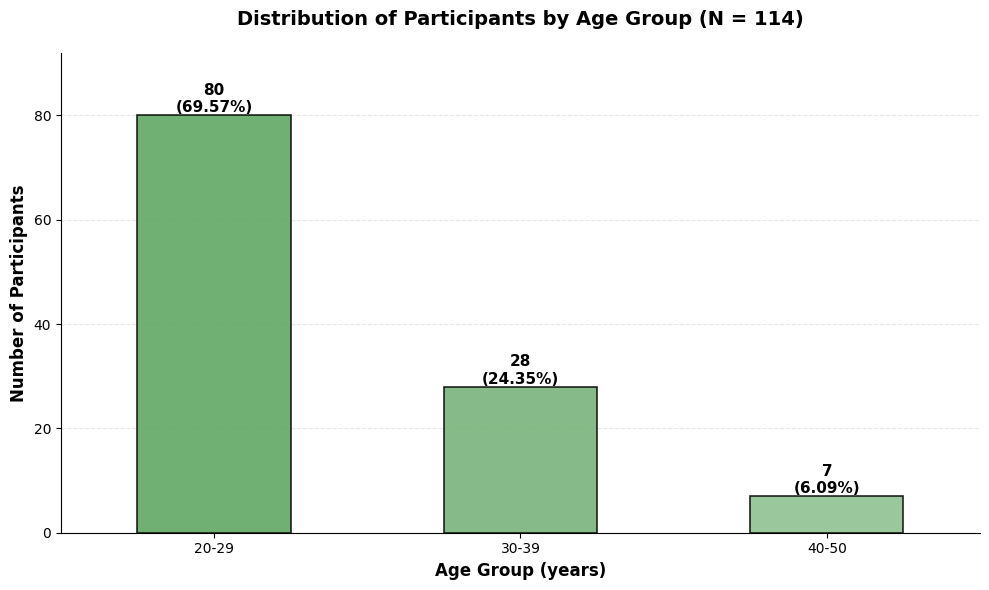


Age Group Distribution Summary:
20-29     :  80 participants (69.57%)
30-39     :  28 participants (24.35%)
40-50     :   7 participants ( 6.09%)
Total     : 115 participants (100.00%)


In [232]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Count participants by age group
age_counts = clean_df['AGE'].value_counts().sort_index()

# Define age group order for proper display
age_order = ['20-29', '30-39', '40-50']
age_counts = age_counts.reindex(age_order, fill_value=0)

# Calculate percentages
total = age_counts.sum()
age_percentages = (age_counts / total * 100).round(2)

# Prepare data for seaborn
age_data = pd.DataFrame({
    'Age Group': age_counts.index,
    'Count': age_counts.values,
    'Percentage': age_percentages.values
})

# Create the bar chart using seaborn
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#4CAF50', '#66BB6A', '#81C784']

# Use seaborn barplot
bars = sns.barplot(data=age_data, x='Age Group', y='Count', hue='Age Group', palette=colors,
                   width=0.5, edgecolor='black', linewidth=1.2, alpha=0.85, ax=ax, legend=False)

# Customize the plot
ax.set_xlabel('Age Group (years)', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax.set_title('Distribution of Participants by Age Group (N = 114)', 
             fontsize=14, fontweight='bold', pad=20)

# Add value labels on top of bars
for i, (count, pct) in enumerate(zip(age_data['Count'], age_data['Percentage'])):
    ax.text(i, count, f'{int(count)}\n({pct}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add grid for better readability
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

# Set y-axis to start from 0
ax.set_ylim(0, age_data['Count'].max() * 1.15)

# Remove top and right spines
sns.despine()

# Make the plot more professional
plt.tight_layout()

# Save the figure
age_chart_path = os.path.join(output_dir, 'age_group_distribution.png')
plt.savefig(age_chart_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Age group distribution chart saved to: {age_chart_path}")

plt.show()

# Print summary statistics
print("\nAge Group Distribution Summary:")
print("="*50)
for age_group, count, pct in zip(age_counts.index, age_counts.values, age_percentages.values):
    print(f"{age_group:10s}: {int(count):3d} participants ({pct:5.2f}%)")
print("="*50)
print(f"{'Total':10s}: {int(total):3d} participants (100.00%)")

## Severity Distribution Analysis

Visualization of SVQ symptom severity distribution across participants

✓ Severity distribution chart saved to: output/severity_distribution.png


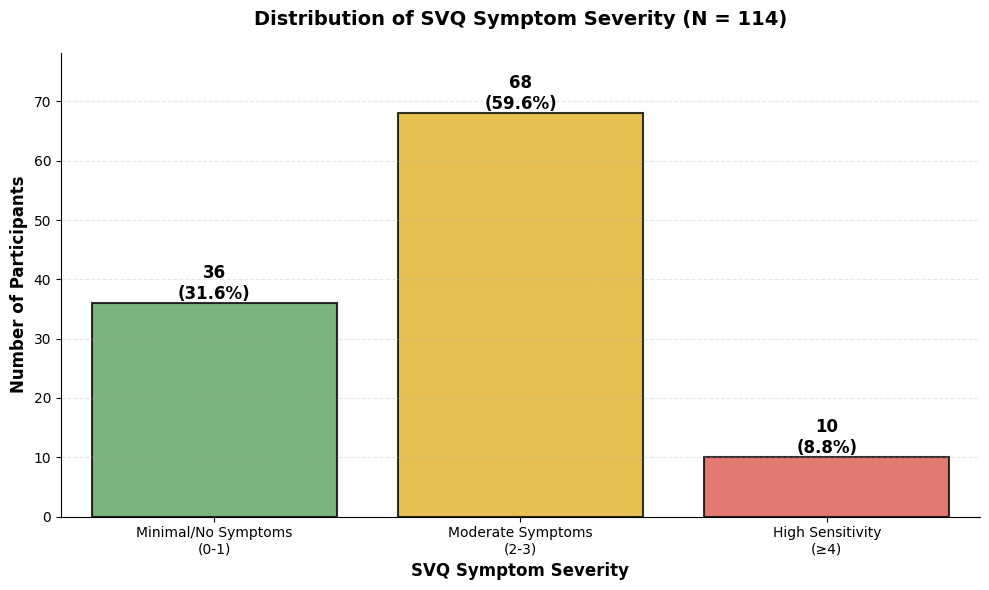

In [228]:
# Severity Distribution Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Get severity distribution (excluding Unknown)
severity_data = clean_df[clean_df['SVQ Interpretation'] != 'Unknown']['SVQ Interpretation'].value_counts()

# Define order and labels
severity_order = ['Minimal/No Symptoms', 'Moderate Symptoms', 'High Sensitivity']
severity_labels = ['Minimal/No Symptoms\n(0-1)', 'Moderate Symptoms\n(2-3)', 'High Sensitivity\n(≥4)']
counts = [severity_data.get(cat, 0) for cat in severity_order]
percentages = [(count / sum(counts)) * 100 for count in counts]

# Prepare data for seaborn
severity_df = pd.DataFrame({
    'Category': severity_labels,
    'Count': counts,
    'Percentage': percentages
})

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar chart using seaborn
colors = ['#4CAF50', '#FFC107', '#F44336']  # Green, Amber, Red
bars = sns.barplot(data=severity_df, x='Category', y='Count', hue='Category', palette=colors,
                   alpha=0.8, edgecolor='black', linewidth=1.5, ax=ax, legend=False)

# Add value labels on bars
for i, (count, pct) in enumerate(zip(severity_df['Count'], severity_df['Percentage'])):
    ax.text(i, count, f'{count}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Styling
ax.set_xlabel('SVQ Symptom Severity', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Participants', fontsize=12, fontweight='bold')
ax.set_title('Distribution of SVQ Symptom Severity (N = 114)', fontsize=14, fontweight='bold', pad=20)
ax.set_ylim(0, max(counts) * 1.15)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Remove top and right spines
sns.despine()

plt.tight_layout()

# Save figure
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
severity_chart_path = os.path.join(output_dir, 'severity_distribution.png')
plt.savefig(severity_chart_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✓ Severity distribution chart saved to: {severity_chart_path}")

plt.show()

In [217]:
# Print summary
print("\n" + "="*60)
print("SEVERITY DISTRIBUTION SUMMARY")
print("="*60)
for label, count, pct in zip(severity_order, counts, percentages):
    print(f"{label:25s}: {count:3d} ({pct:5.2f}%)")
print("="*60)
print(f"Total (excluding Unknown): {sum(counts)}")
print("="*60)


SEVERITY DISTRIBUTION SUMMARY
Minimal/No Symptoms      :  36 (31.58%)
Moderate Symptoms        :  68 (59.65%)
High Sensitivity         :  10 ( 8.77%)
Total (excluding Unknown): 114


## Association Analysis

Testing relationships between screen time, earphone usage, and SVQ scores

In [218]:
# Association Analysis: Screen Time, Earphone Usage, and SVQ Score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Prepare data (exclude Unknown SVQ status)
correlation_df = clean_df[clean_df['SVQ Interpretation'] != 'Unknown'].copy()

# Ensure we have the mapped variables from Table 1 preparation
screen_col = "HOW MANY HOURS DO YOU SPEND IN FRONT OF SCREEN DAILY?"
screen_mapping = {
    "> 8 hours": 8.5,
    "6-8 hours": 7,
    "4-6 hours": 5,
    "<4 hours": 2,
}
correlation_df['Screen_hours'] = correlation_df[screen_col].map(screen_mapping)

earphone_col = "IF YES THEN FOR HOW MANY HOURS?"
earphone_mapping = {
    "<4 hours": 2,
    "4-6 hours4": 5,
    "6-8 hours": 7,
    ">8hours": 8.5,
}
correlation_df['Earphone_hours'] = correlation_df[earphone_col].map(earphone_mapping)

# Extract variables for analysis
screen_time = correlation_df['Screen_hours'].dropna()
earphone_usage = correlation_df['Earphone_hours'].dropna()
svq_scores = correlation_df['SVQ Score'].dropna()

# Align data (only complete cases)
complete_screen = correlation_df[['Screen_hours', 'SVQ Score']].dropna()
complete_earphone = correlation_df[['Earphone_hours', 'SVQ Score']].dropna()

print("="*70)
print("ASSOCIATION ANALYSIS: SCREEN TIME & EARPHONE USAGE vs SVQ SCORE")
print("="*70)

# ===== 1. NORMALITY TESTS (Shapiro-Wilk) =====
print("\n" + "="*70)
print("1. NORMALITY TESTS (Shapiro-Wilk)")
print("="*70)

# Test Screen Time
stat_screen, p_screen = stats.shapiro(complete_screen['Screen_hours'])
print(f"\nScreen Time (hours/day):")
print(f"  W-statistic: {stat_screen:.4f}")
print(f"  p-value: {p_screen:.4f}")
print(f"  Distribution: {'Normal' if p_screen > 0.05 else 'Non-normal'} (α = 0.05)")

# Test Earphone Usage
stat_earphone, p_earphone = stats.shapiro(complete_earphone['Earphone_hours'])
print(f"\nEarphone Usage (hours/day):")
print(f"  W-statistic: {stat_earphone:.4f}")
print(f"  p-value: {p_earphone:.4f}")
print(f"  Distribution: {'Normal' if p_earphone > 0.05 else 'Non-normal'} (α = 0.05)")

# Test SVQ Score
stat_svq, p_svq = stats.shapiro(svq_scores)
print(f"\nSVQ Score:")
print(f"  W-statistic: {stat_svq:.4f}")
print(f"  p-value: {p_svq:.4f}")
print(f"  Distribution: {'Normal' if p_svq > 0.05 else 'Non-normal'} (α = 0.05)")


ASSOCIATION ANALYSIS: SCREEN TIME & EARPHONE USAGE vs SVQ SCORE

1. NORMALITY TESTS (Shapiro-Wilk)

Screen Time (hours/day):
  W-statistic: 0.8011
  p-value: 0.0000
  Distribution: Non-normal (α = 0.05)

Earphone Usage (hours/day):
  W-statistic: 0.8383
  p-value: 0.0000
  Distribution: Non-normal (α = 0.05)

SVQ Score:
  W-statistic: 0.9676
  p-value: 0.0073
  Distribution: Non-normal (α = 0.05)


In [219]:
# ===== 2. CORRELATION ANALYSIS =====
print("\n" + "="*70)
print("2. CORRELATION ANALYSIS")
print("="*70)

# Determine which correlation method to use
use_pearson = (p_screen > 0.05) and (p_svq > 0.05)
method_screen = "Pearson" if use_pearson else "Spearman"

use_pearson_earphone = (p_earphone > 0.05) and (p_svq > 0.05)
method_earphone = "Pearson" if use_pearson_earphone else "Spearman"

# Screen Time vs SVQ Score
if use_pearson:
    r_screen, p_val_screen = stats.pearsonr(complete_screen['Screen_hours'], complete_screen['SVQ Score'])
else:
    r_screen, p_val_screen = stats.spearmanr(complete_screen['Screen_hours'], complete_screen['SVQ Score'])

print(f"\n📊 Screen Time vs SVQ Score ({method_screen} Correlation):")
print(f"  Correlation coefficient (r): {r_screen:.4f}")
print(f"  p-value: {p_val_screen:.4f}")
print(f"  Significance: {'Significant' if p_val_screen < 0.05 else 'Not significant'} (α = 0.05)")
print(f"  N (complete pairs): {len(complete_screen)}")
if abs(r_screen) < 0.3:
    strength = "Weak"
elif abs(r_screen) < 0.7:
    strength = "Moderate"
else:
    strength = "Strong"
direction = "positive" if r_screen > 0 else "negative"
print(f"  Interpretation: {strength} {direction} correlation")

# Earphone Usage vs SVQ Score
if use_pearson_earphone:
    r_earphone, p_val_earphone = stats.pearsonr(complete_earphone['Earphone_hours'], complete_earphone['SVQ Score'])
else:
    r_earphone, p_val_earphone = stats.spearmanr(complete_earphone['Earphone_hours'], complete_earphone['SVQ Score'])

print(f"\n🎧 Earphone Usage vs SVQ Score ({method_earphone} Correlation):")
print(f"  Correlation coefficient (r): {r_earphone:.4f}")
print(f"  p-value: {p_val_earphone:.4f}")
print(f"  Significance: {'Significant' if p_val_earphone < 0.05 else 'Not significant'} (α = 0.05)")
print(f"  N (complete pairs): {len(complete_earphone)}")
if abs(r_earphone) < 0.3:
    strength = "Weak"
elif abs(r_earphone) < 0.7:
    strength = "Moderate"
else:
    strength = "Strong"
direction = "positive" if r_earphone > 0 else "negative"
print(f"  Interpretation: {strength} {direction} correlation")

print("\n" + "="*70)


2. CORRELATION ANALYSIS

📊 Screen Time vs SVQ Score (Spearman Correlation):
  Correlation coefficient (r): -0.1564
  p-value: 0.0965
  Significance: Not significant (α = 0.05)
  N (complete pairs): 114
  Interpretation: Weak negative correlation

🎧 Earphone Usage vs SVQ Score (Spearman Correlation):
  Correlation coefficient (r): 0.4133
  p-value: 0.0000
  Significance: Significant (α = 0.05)
  N (complete pairs): 114
  Interpretation: Moderate positive correlation




✓ Correlation heatmap saved to: output/correlation_heatmap.png


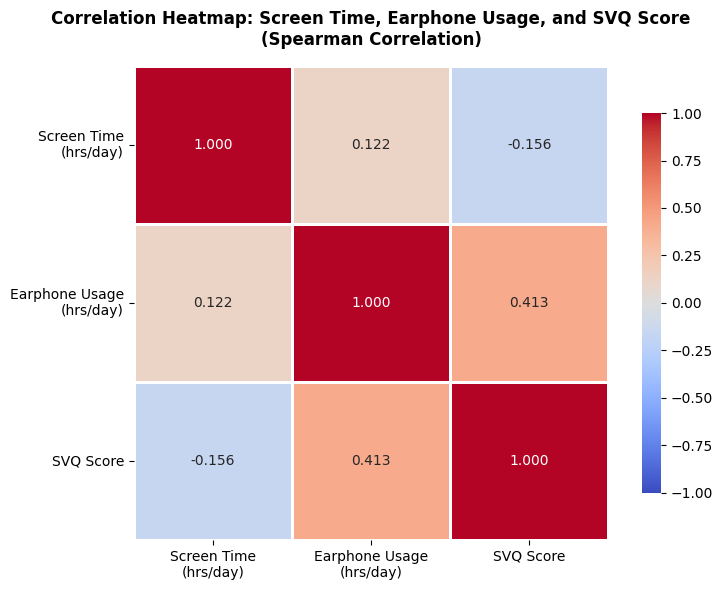


SUMMARY TABLE: CORRELATION RESULTS
                  Variables   Method r value p value Significance   N
   Screen Time vs SVQ Score Spearman -0.1564  0.0965           No 114
Earphone Usage vs SVQ Score Spearman  0.4133  0.0000        Yes** 114

* p < 0.05, ** p < 0.01


In [220]:

# ===== 3. CORRELATION HEATMAP =====
# Create correlation matrix
correlation_vars = correlation_df[['Screen_hours', 'Earphone_hours', 'SVQ Score']].dropna()
corr_matrix = correlation_vars.corr(method='spearman')

# Create heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)

ax.set_title('Correlation Heatmap: Screen Time, Earphone Usage, and SVQ Score\n(Spearman Correlation)', 
             fontsize=12, fontweight='bold', pad=15)
ax.set_xticklabels(['Screen Time\n(hrs/day)', 'Earphone Usage\n(hrs/day)', 'SVQ Score'], rotation=0)
ax.set_yticklabels(['Screen Time\n(hrs/day)', 'Earphone Usage\n(hrs/day)', 'SVQ Score'], rotation=0)

plt.tight_layout()

# Save heatmap
output_dir = 'output'
os.makedirs(output_dir, exist_ok=True)
heatmap_path = os.path.join(output_dir, 'correlation_heatmap.png')
plt.savefig(heatmap_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Correlation heatmap saved to: {heatmap_path}")

plt.show()

# ===== 4. SUMMARY TABLE =====
print("\n" + "="*70)
print("SUMMARY TABLE: CORRELATION RESULTS")
print("="*70)

summary_data = {
    'Variables': ['Screen Time vs SVQ Score', 'Earphone Usage vs SVQ Score'],
    'Method': [method_screen, method_earphone],
    'r value': [f'{r_screen:.4f}', f'{r_earphone:.4f}'],
    'p value': [f'{p_val_screen:.4f}', f'{p_val_earphone:.4f}'],
    'Significance': [
        'Yes**' if p_val_screen < 0.01 else 'Yes*' if p_val_screen < 0.05 else 'No',
        'Yes**' if p_val_earphone < 0.01 else 'Yes*' if p_val_earphone < 0.05 else 'No'
    ],
    'N': [len(complete_screen), len(complete_earphone)]
}

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print("\n* p < 0.05, ** p < 0.01")
print("="*70)

## Group Comparisons

Comparing SVQ scores across demographic groups (Gender and Job Role)

GROUP COMPARISONS: GENDER & JOB ROLE vs SVQ SCORE

1. GENDER vs SVQ SCORE

Group Sizes:
  Female: n = 52
  Male: n = 62

✓ Sufficient sample sizes for gender comparison

Descriptive Statistics by Gender:
        count      mean       std    median  min       max
GENDER                                                    
Female     52  1.866211  0.855607  2.000000  0.0  3.315789
Male       62  1.423123  1.101384  1.263158  0.0  4.000000

Normality Tests (Shapiro-Wilk) by Gender:
  Female: W = 0.9682, p = 0.1775 (Normal)
  Male: W = 0.9418, p = 0.0055 (Non-normal)

Mann-Whitney U test Results:
  U-statistic: 2049.5000
  p-value: 0.0129
  Significance: Yes (α = 0.05)
  Rank-biserial correlation: -0.2714 (Small effect size)

Interpretation:
  Mean difference (Female - Male): 0.4431
  Female showed significantly higher SVQ scores than Male.

✓ Gender comparison boxplot saved to: output/gender_svq_boxplot.png


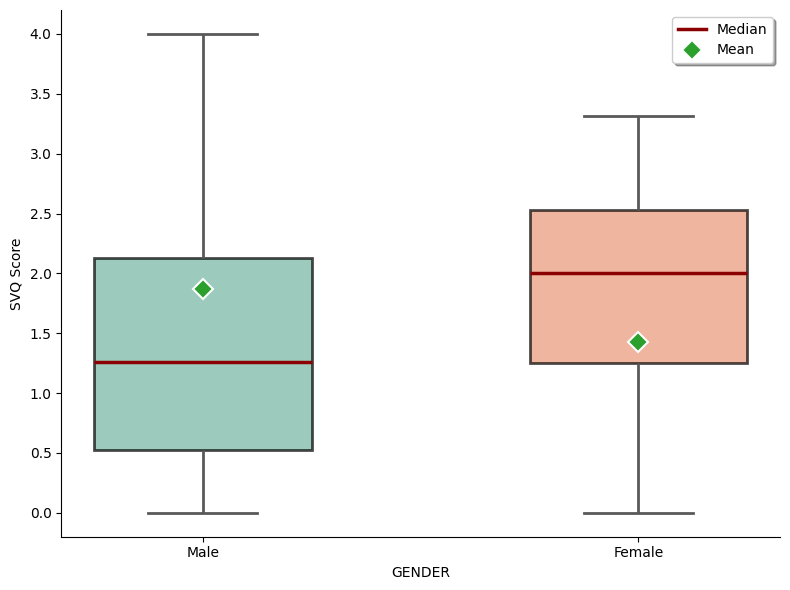

In [235]:
# Group Comparisons: Gender and Job Role vs SVQ Score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Use the same dataset as previous analyses
comparison_df = clean_df[clean_df['SVQ Interpretation'] != 'Unknown'].copy()

print("="*70)
print("GROUP COMPARISONS: GENDER & JOB ROLE vs SVQ SCORE")
print("="*70)

# ===== 1. GENDER vs SVQ SCORE =====
print("\n" + "="*70)
print("1. GENDER vs SVQ SCORE")
print("="*70)

# Check group sizes
gender_groups = comparison_df.groupby('GENDER')['SVQ Score'].apply(list)
print("\nGroup Sizes:")
for gender, scores in gender_groups.items():
    print(f"  {gender}: n = {len(scores)}")

# Check if we have reasonable group sizes (at least 2 groups with n >= 5)
valid_groups = {k: v for k, v in gender_groups.items() if len(v) >= 5}

if len(valid_groups) >= 2:
    print("\n✓ Sufficient sample sizes for gender comparison")
    
    # Descriptive statistics by gender
    print("\nDescriptive Statistics by Gender:")
    gender_stats = comparison_df.groupby('GENDER')['SVQ Score'].agg(['count', 'mean', 'std', 'median', 'min', 'max'])
    print(gender_stats.to_string())
    
    # Test for normality within each group (Shapiro-Wilk)
    print("\nNormality Tests (Shapiro-Wilk) by Gender:")
    normality_results = {}
    for gender, scores in valid_groups.items():
        stat, p = stats.shapiro(scores)
        normality_results[gender] = (stat, p)
        print(f"  {gender}: W = {stat:.4f}, p = {p:.4f} ({'Normal' if p > 0.05 else 'Non-normal'})")
    
    # Determine test to use
    all_normal = all(p > 0.05 for _, p in normality_results.values())
    
    if len(valid_groups) == 2:
        # Two groups: t-test or Mann-Whitney U
        group_names = list(valid_groups.keys())
        group1 = valid_groups[group_names[0]]
        group2 = valid_groups[group_names[1]]
        
        if all_normal:
            # Check homogeneity of variance (Levene's test)
            stat_levene, p_levene = stats.levene(group1, group2)
            print(f"\nLevene's Test (Homogeneity of Variance): F = {stat_levene:.4f}, p = {p_levene:.4f}")
            
            if p_levene > 0.05:
                # Independent t-test with equal variance
                t_stat, p_val = stats.ttest_ind(group1, group2)
                test_name = "Independent t-test"
            else:
                # Welch's t-test (unequal variance)
                t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
                test_name = "Welch's t-test"
            
            print(f"\n{test_name} Results:")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_val:.4f}")
            print(f"  Significance: {'Yes' if p_val < 0.05 else 'No'} (α = 0.05)")
            
            # Calculate Cohen's d (effect size)
            pooled_std = np.sqrt(((len(group1) - 1) * np.std(group1, ddof=1)**2 + 
                                   (len(group2) - 1) * np.std(group2, ddof=1)**2) / 
                                  (len(group1) + len(group2) - 2))
            cohens_d = (np.mean(group1) - np.mean(group2)) / pooled_std
            print(f"  Cohen's d: {cohens_d:.4f} ({'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'} effect size)")
        else:
            # Mann-Whitney U test (non-parametric)
            u_stat, p_val = stats.mannwhitneyu(group1, group2, alternative='two-sided')
            test_name = "Mann-Whitney U test"
            
            print(f"\n{test_name} Results:")
            print(f"  U-statistic: {u_stat:.4f}")
            print(f"  p-value: {p_val:.4f}")
            print(f"  Significance: {'Yes' if p_val < 0.05 else 'No'} (α = 0.05)")
            
            # Calculate rank-biserial correlation (effect size)
            r_rb = 1 - (2*u_stat) / (len(group1) * len(group2))
            print(f"  Rank-biserial correlation: {r_rb:.4f} ({'Small' if abs(r_rb) < 0.3 else 'Medium' if abs(r_rb) < 0.5 else 'Large'} effect size)")
        
        # Interpretation
        mean_diff = np.mean(group1) - np.mean(group2)
        print(f"\nInterpretation:")
        print(f"  Mean difference ({group_names[0]} - {group_names[1]}): {mean_diff:.4f}")
        if p_val < 0.05:
            print(f"  {group_names[0]} showed {'significantly higher' if mean_diff > 0 else 'significantly lower'} SVQ scores than {group_names[1]}.")
        else:
            print(f"  No significant difference in SVQ scores between {group_names[0]} and {group_names[1]}.")
    
    else:
        # More than 2 groups: ANOVA or Kruskal-Wallis
        groups_data = [scores for scores in valid_groups.values()]
        
        if all_normal:
            # Check homogeneity of variance (Levene's test)
            stat_levene, p_levene = stats.levene(*groups_data)
            print(f"\nLevene's Test (Homogeneity of Variance): F = {stat_levene:.4f}, p = {p_levene:.4f}")
            
            if p_levene > 0.05:
                # One-way ANOVA
                f_stat, p_val = stats.f_oneway(*groups_data)
                test_name = "One-way ANOVA"
                
                print(f"\n{test_name} Results:")
                print(f"  F-statistic: {f_stat:.4f}")
                print(f"  p-value: {p_val:.4f}")
                print(f"  Significance: {'Yes' if p_val < 0.05 else 'No'} (α = 0.05)")
            else:
                # Welch's ANOVA (unequal variance)
                print("\nNote: Unequal variances detected. Consider using Kruskal-Wallis test.")
                h_stat, p_val = stats.kruskal(*groups_data)
                test_name = "Kruskal-Wallis H test"
                
                print(f"\n{test_name} Results:")
                print(f"  H-statistic: {h_stat:.4f}")
                print(f"  p-value: {p_val:.4f}")
                print(f"  Significance: {'Yes' if p_val < 0.05 else 'No'} (α = 0.05)")
        else:
            # Kruskal-Wallis test (non-parametric)
            h_stat, p_val = stats.kruskal(*groups_data)
            test_name = "Kruskal-Wallis H test"
            
            print(f"\n{test_name} Results:")
            print(f"  H-statistic: {h_stat:.4f}")
            print(f"  p-value: {p_val:.4f}")
            print(f"  Significance: {'Yes' if p_val < 0.05 else 'No'} (α = 0.05)")
        
        if p_val < 0.05:
            print(f"\nInterpretation: Significant differences in SVQ scores across gender groups.")
            print("Post-hoc tests would be needed to identify specific group differences.")
        else:
            print(f"\nInterpretation: No significant differences in SVQ scores across gender groups.")
    
    # Visualization: Box plot for Gender vs SVQ Score using seaborn
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Filter data for valid groups
    valid_gender_data = comparison_df[comparison_df['GENDER'].isin(
        [g for g in comparison_df['GENDER'].unique() 
         if len(comparison_df[comparison_df['GENDER'] == g]) >= 5])]
    
    # Create seaborn boxplot with improved styling
    box = sns.boxplot(data=valid_gender_data, x='GENDER', y='SVQ Score', hue='GENDER',
                      palette=['#66c2a5', '#fc8d62'], fill=True, legend=False,
                      linewidth=2, width=0.5, ax=ax)
    
    # Customize box appearance
    for patch in box.patches:
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
    
    # Customize median lines
    for line in box.lines[4::6]:  # median lines
        line.set_color('darkred')
        line.set_linewidth(2.5)
    
    # Add mean markers
    means = valid_gender_data.groupby('GENDER')['SVQ Score'].mean()
    positions = range(len(means))
    ax.plot(positions, means.values, marker='D', linestyle='', 
            markerfacecolor='#2ca02c', markersize=10, markeredgecolor='white', markeredgewidth=1.5,
            label='Mean', zorder=3)
    
    legend_elements = [Line2D([0], [0], color='darkred', linewidth=2.5, label='Median'),
                      Line2D([0], [0], marker='D', color='w', markerfacecolor='#2ca02c', 
                             markersize=10, markeredgecolor='white', markeredgewidth=1.5, label='Mean')]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, shadow=True)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='darkred', linewidth=2.5, label='Median'),
                      Line2D([0], [0], marker='D', color='w', markerfacecolor='#2ca02c', 
                             markersize=10, markeredgecolor='white', markeredgewidth=1.5, label='Mean')]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, shadow=True)
    
    # Remove top and right spines
    sns.despine()
    
    plt.tight_layout()
    
    # Save figure
    output_dir = 'output'
    os.makedirs(output_dir, exist_ok=True)
    gender_boxplot_path = os.path.join(output_dir, 'gender_svq_boxplot.png')
    plt.savefig(gender_boxplot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Gender comparison boxplot saved to: {gender_boxplot_path}")
    
    plt.show()

else:
    print("\n✗ Insufficient sample sizes for gender comparison (need at least 2 groups with n ≥ 5)")

    
    plt.show()


2. JOB ROLE vs SVQ SCORE

Group Sizes:
  Analyst: n = 1
  Associate: n = 1
  Backend Engg: n = 1
  Consultant: n = 1
  Coordinator Logistics: n = 1
  Data Analyst: n = 6
  Data Engineer: n = 1
  Desktop Support Engineer: n = 1
  Developer: n = 1
  Engineer: n = 4
  Er: n = 1
  Executive: n = 1
  Full Stack Developer: n = 1
  IT: n = 22
  IT Professional: n = 1
  IT Worker: n = 8
  It - Backend Engineer: n = 1
  It Analyst: n = 1
  It Campus Head: n = 1
  It Engineer: n = 3
  It Intern: n = 1
  Lead Consultant Sap Trm: n = 1
  Manufacturing Quality: n = 1
  Marketing Designer: n = 1
  Mis - Manager: n = 1
  Petroleum Engineer: n = 1
  Private Sector: n = 1
  Quality Analysts: n = 1
  Reporting  Associate: n = 1
  Senior Engineer: n = 1
  Senior Software Engineer: n = 1
  Software Developer: n = 17
  Software Developers: n = 1
  Software Development Intern: n = 1
  Software Engineer: n = 12
  Solution Advisor: n = 1
  Supply Chain Analyst: n = 1
  System Implementor: n = 1
  Tech Archit

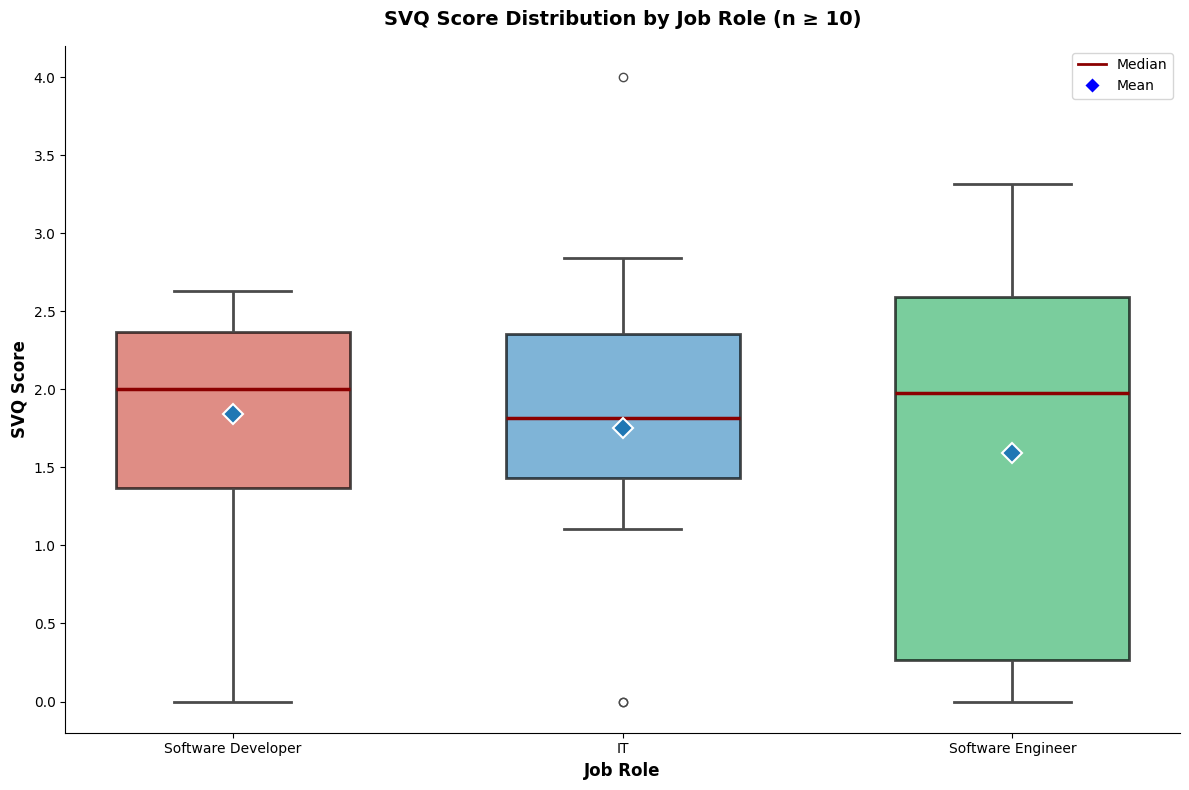


GROUP COMPARISON ANALYSIS COMPLETE


In [237]:
# ===== 2. JOB ROLE vs SVQ SCORE =====
print("\n" + "="*70)
print("2. JOB ROLE vs SVQ SCORE")
print("="*70)

# Check group sizes
job_groups = comparison_df.groupby('JOB ROLE')['SVQ Score'].apply(list)
print("\nGroup Sizes:")
for job, scores in job_groups.items():
    print(f"  {job}: n = {len(scores)}")

# Filter to keep only job roles with reasonable sample sizes (n >= 10 for ANOVA)
valid_job_groups = {k: v for k, v in job_groups.items() if len(v) >= 10}

if len(valid_job_groups) >= 2:
    print(f"\n✓ Sufficient sample sizes for job role comparison ({len(valid_job_groups)} groups with n ≥ 10)")
    
    # Filter comparison_df to include only valid job roles
    valid_jobs = list(valid_job_groups.keys())
    job_comparison_df = comparison_df[comparison_df['JOB ROLE'].isin(valid_jobs)].copy()
    
    # Descriptive statistics by job role
    print("\nDescriptive Statistics by Job Role:")
    job_stats = job_comparison_df.groupby('JOB ROLE')['SVQ Score'].agg(['count', 'mean', 'std', 'median', 'min', 'max'])
    print(job_stats.to_string())
    
    # Test for normality within each group
    print("\nNormality Tests (Shapiro-Wilk) by Job Role:")
    normality_results_job = {}
    for job, scores in valid_job_groups.items():
        stat, p = stats.shapiro(scores)
        normality_results_job[job] = (stat, p)
        print(f"  {job}: W = {stat:.4f}, p = {p:.4f} ({'Normal' if p > 0.05 else 'Non-normal'})")
    
    # Determine test to use
    all_normal_job = all(p > 0.05 for _, p in normality_results_job.values())
    
    # Prepare data for statistical test
    job_groups_data = [scores for scores in valid_job_groups.values()]
    
    if all_normal_job:
        # Check homogeneity of variance (Levene's test)
        stat_levene, p_levene = stats.levene(*job_groups_data)
        print(f"\nLevene's Test (Homogeneity of Variance): F = {stat_levene:.4f}, p = {p_levene:.4f}")
        
        if p_levene > 0.05:
            # One-way ANOVA
            f_stat, p_val = stats.f_oneway(*job_groups_data)
            test_name = "One-way ANOVA"
            
            print(f"\n{test_name} Results:")
            print(f"  F-statistic: {f_stat:.4f}")
            print(f"  p-value: {p_val:.4f}")
            print(f"  Significance: {'Yes' if p_val < 0.05 else 'No'} (α = 0.05)")
        else:
            # Use Kruskal-Wallis due to unequal variances
            print("\nNote: Unequal variances detected. Using Kruskal-Wallis test.")
            h_stat, p_val = stats.kruskal(*job_groups_data)
            test_name = "Kruskal-Wallis H test"
            
            print(f"\n{test_name} Results:")
            print(f"  H-statistic: {h_stat:.4f}")
            print(f"  p-value: {p_val:.4f}")
            print(f"  Significance: {'Yes' if p_val < 0.05 else 'No'} (α = 0.05)")
    else:
        # Kruskal-Wallis test (non-parametric)
        h_stat, p_val = stats.kruskal(*job_groups_data)
        test_name = "Kruskal-Wallis H test"
        
        print(f"\n{test_name} Results:")
        print(f"  H-statistic: {h_stat:.4f}")
        print(f"  p-value: {p_val:.4f}")
        print(f"  Significance: {'Yes' if p_val < 0.05 else 'No'} (α = 0.05)")
    
    if p_val < 0.05:
        print(f"\nInterpretation: Significant differences in SVQ scores across job role groups.")
        print("Post-hoc tests (e.g., Dunn's test) would be needed to identify specific group differences.")
    else:
        print(f"\nInterpretation: No significant differences in SVQ scores across job role groups.")
    
    # Visualization: Box plot for Job Role vs SVQ Score using seaborn
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create seaborn boxplot with improved styling
    box = sns.boxplot(data=job_comparison_df, x='JOB ROLE', y='SVQ Score', hue='JOB ROLE',
                      palette=['#e74c3c', '#3498db', '#2ecc71'], fill=True, legend=False,
                      linewidth=2, width=0.6, ax=ax)
    
    # Customize box appearance
    for patch in box.patches:
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
    
    # Customize median lines
    for line in box.lines[4::6]:  # median lines
        line.set_color('darkred')
        line.set_linewidth(2.5)
    
    # Add mean markers
    means = job_comparison_df.groupby('JOB ROLE')['SVQ Score'].mean()
    positions = range(len(means))
    ax.plot(positions, means.values, marker='D', linestyle='', 
            markerfacecolor='#1f77b4', markersize=10, markeredgecolor='white', markeredgewidth=1.5,
            label='Mean', zorder=3)
    
    ax.set_xlabel('Job Role', fontsize=12, fontweight='bold')
    ax.set_ylabel('SVQ Score', fontsize=12, fontweight='bold')
    ax.set_title(f'SVQ Score Distribution by Job Role (n ≥ 10)', fontsize=14, fontweight='bold', pad=15)
    legend_elements = [Line2D([0], [0], color='darkred', linewidth=2.5, label='Median'),
                      Line2D([0], [0], marker='D', color='w', markerfacecolor='#1f77b4', 
                             markersize=10, markeredgecolor='white', markeredgewidth=1.5, label='Mean')]
    ax.legend(handles=legend_elements, loc='upper right', frameon=True, shadow=True)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], color='darkred', linewidth=2, label='Median'),
                      Line2D([0], [0], marker='D', color='w', markerfacecolor='blue', 
                             markersize=8, label='Mean')]
    ax.legend(handles=legend_elements, loc='upper right')
    
    # Remove top and right spines
    sns.despine()
    
    plt.tight_layout()
    
    # Save figure
    job_boxplot_path = os.path.join(output_dir, 'job_role_svq_boxplot.png')
    plt.savefig(job_boxplot_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Job role comparison boxplot saved to: {job_boxplot_path}")
    
    plt.show()

else:
    print(f"\n✗ Insufficient sample sizes for job role comparison (need at least 2 groups with n ≥ 10)")
    print("Job roles with n < 10:")
    for job, scores in job_groups.items():
        if len(scores) < 10:
            print(f"  {job}: n = {len(scores)}")

print("\n" + "="*70)
print("GROUP COMPARISON ANALYSIS COMPLETE")
print("="*70)

In [223]:
# Summary table for group comparisons
print("\n" + "="*70)
print("SUMMARY TABLE: GROUP COMPARISON RESULTS")
print("="*70)

summary_comparisons = []

# Gender comparison summary
if len(valid_groups) >= 2:
    summary_comparisons.append({
        'Comparison': 'Gender vs SVQ Score',
        'Groups': f"{len(valid_groups)} groups",
        'Test': test_name if 'test_name' in locals() else 'N/A',
        'p-value': f"{p_val:.4f}" if 'p_val' in locals() else 'N/A',
        'Significance': 'Yes' if 'p_val' in locals() and p_val < 0.05 else 'No'
    })

# Job role comparison summary
if len(valid_job_groups) >= 2:
    summary_comparisons.append({
        'Comparison': 'Job Role vs SVQ Score',
        'Groups': f"{len(valid_job_groups)} groups",
        'Test': test_name if 'test_name' in locals() else 'N/A',
        'p-value': f"{p_val:.4f}" if 'p_val' in locals() else 'N/A',
        'Significance': 'Yes' if 'p_val' in locals() and p_val < 0.05 else 'No'
    })

if summary_comparisons:
    summary_comp_df = pd.DataFrame(summary_comparisons)
    print(summary_comp_df.to_string(index=False))
    print("\nα = 0.05")
else:
    print("No valid group comparisons performed.")

print("="*70)


SUMMARY TABLE: GROUP COMPARISON RESULTS
           Comparison   Groups                  Test p-value Significance
  Gender vs SVQ Score 2 groups Kruskal-Wallis H test  0.9923           No
Job Role vs SVQ Score 3 groups Kruskal-Wallis H test  0.9923           No

α = 0.05
